#  **Multiclass Text Classification - Fine Tuning using DistilBERT**

Dataset Link - https://github.com/parthebhan/Multiclass-text-classification-fine-tuning-distilbert/blob/9fe109b3a4fa824dc4fbbefebc09651316488258/bbc-text.csv

## **Pretrained Training data - (Distilbert-base-uncased)**

Model Detail - https://huggingface.co/distilbert/distilbert-base-uncased

DistilBERT pretrained on the same data as BERT, which is BookCorpus, a dataset consisting of 11,038 unpublished books and English Wikipedia (excluding lists, tables and headers).
Training procedure
Preprocessing

The texts are lowercased and tokenized using WordPiece and a vocabulary size of 30,000. The inputs of the model are then of the form:

[CLS] Sentence A [SEP] Sentence B [SEP]

With probability 0.5, sentence A and sentence B correspond to two consecutive sentences in the original corpus and in the other cases, it's another random sentence in the corpus. Note that what is considered a sentence here is a consecutive span of text usually longer than a single sentence. The only constrain is that the result with the two "sentences" has a combined length of less than 512 tokens.

The details of the masking procedure for each sentence are the following:

    15% of the tokens are masked.
    In 80% of the cases, the masked tokens are replaced by [MASK].
    In 10% of the cases, the masked tokens are replaced by a random token (different) from the one they replace.
    In the 10% remaining cases, the masked tokens are left as is.


-----------------------

![Imgur](https://www.researchgate.net/profile/Juan-Pablo-Usuga-Cadavid/publication/353419108/figure/fig1/AS:1052388236476416@1627920316521/Example-of-a-trained-BERT-for-text-classification.ppm)

-------------------------




In [5]:
!pip  install transformers tensorflow keras

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spinners import open_spinner
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/spinners.py", line 9, in <module>
    from pip._internal.utils.logging import get_indentation
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/utils/logging.py", line 125, in <module>
    class IndentedRe

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
px.defaults.template = 'plotly_dark'

import tensorflow as tf

import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import warnings
warnings.filterwarnings('ignore')

In [7]:
root_path = 'https://github.com/parthebhan/Multiclass-text-classification-fine-tuning-distilbert/raw/9fe109b3a4fa824dc4fbbefebc09651316488258/bbc-text.csv'

In [8]:
df = pd.read_csv(root_path)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [9]:
df.shape

(2225, 2)

# Histogram of the count of text

In [10]:
df['count'] = df['text'].apply(lambda x: len(x.split()))

In [11]:
df.head()

,category,text,count
0,tech,tv future in the hands of viewers with home th...,737
1,business,worldcom boss left books alone former worldc...,300
2,sport,tigers wary of farrell gamble leicester say ...,246
3,sport,yeading face newcastle in fa cup premiership s...,341
4,entertainment,ocean s twelve raids box office ocean s twelve...,260


<Figure size 800x800 with 0 Axes>

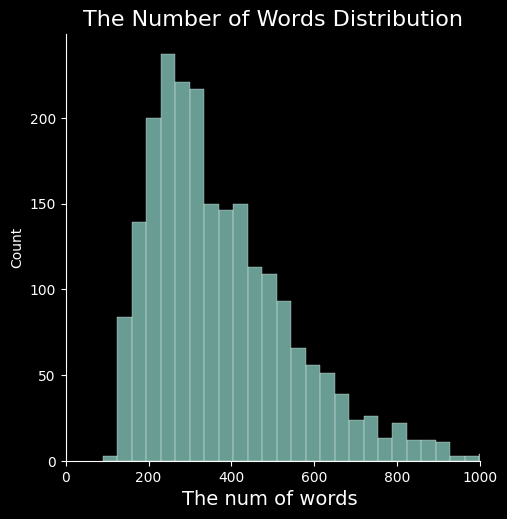

In [16]:
plt.figure(figsize= (8, 8))
plt.style.use('dark_background')

sns.displot(df['count'])

plt.xlim(0, 1000)
plt.grid(False)

plt.xlabel('The num of words ', fontsize = 14)

plt.title("The Number of Words Distribution", fontsize = 16)
plt.show()



# Bar plot for category

In [17]:
category_count = df['category'].value_counts().reset_index()
category_count.columns = ['category', 'count']
category_count

,category,count
0,sport,511
1,business,510
2,politics,417
3,tech,401
4,entertainment,386


In [18]:
fig = px.bar(category_count,
             x='category',
             y='count',
             labels={'category': 'Categories', 'count': 'Counts'},
             height=700,
             width=700,
             text='count',
             title='Counts of Articles by Category',
             color='category',  # Color bars based on categories
             )

fig.show()

In [19]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [23]:
df['encoded_text'] = df['category'].astype('category').cat.codes

df.head(10)

,category,text,count,encoded_text
0,tech,tv future in the hands of viewers with home th...,737,4
1,business,worldcom boss left books alone former worldc...,300,0
2,sport,tigers wary of farrell gamble leicester say ...,246,3
3,sport,yeading face newcastle in fa cup premiership s...,341,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,260,1
5,politics,howard hits back at mongrel jibe michael howar...,633,2
6,politics,blair prepares to name poll date tony blair is...,269,2
7,sport,henman hopes ended in dubai third seed tim hen...,191,3
8,sport,wilkinson fit to face edinburgh england captai...,157,3
9,entertainment,last star wars not for children the sixth an...,237,1


In [24]:
mapping = dict(df[[ 'encoded_text','category']].drop_duplicates().sort_values('encoded_text').values)

print(mapping)

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}


In [25]:
data_texts = df['text'].to_list()

data_labels = df['encoded_text'].to_list()

# Train Test SPlit

In [26]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )


In [27]:
 Test_df = pd.DataFrame({ 'text': test_texts,
                          'label': test_labels
                      })

 Test_df

,text,label
0,dollar hovers around record lows the us dollar...,0
1,profile: david blunkett before he resigned the...,2
2,portishead back after eight years cult british...,1
3,bbc web search aids odd queries the bbc s onli...,4
4,aaliyah claim dismissed by court late r&b star...,1
5,blair stresses prosperity goals tony blair say...,2
6,hewitt falls to dent in adelaide lleyton hewit...,3
7,microsoft takes on desktop search microsoft ha...,4
8,buyers snap up jet airways shares investors h...,0
9,eastwood s baby scoops top oscars clint eastwo...,1


In [17]:
Test_df['text'].sample(5).to_list()

['da vinci code is  lousy history  the plot of an international bestseller that thousands of readers are likely to receive as a christmas present is  laughable   a clergyman has said.  the da vinci code claims jesus was not crucified  but married mary magdalene and died a normal death. it claims this was later covered up by the church. the bishop of durham  the rt rev dr tom wright  described the novel as a  great thriller  but  lousy history . the book has sold more than seven million copies worldwide. despite enjoying dan brown s conspiracy theory  the bishop said there was a lack of evidence to back up its claims.  writing his christmas message in the northern echo  the bishop said:  conspiracy theories are always fun - fun to invent  fun to read  fun to fantasise about.  dan brown is the best writer i ve come across in the genre  but anyone who knows anything about 1st century history will see that this underlying material is laughable.  a great deal of credible evidence proves the

# Model Definition

In [18]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [20]:
train_dataset.element_spec

({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [21]:
for batch in train_dataset.take(1):
    print(batch)

({'input_ids': <tf.Tensor: shape=(512,), dtype=int32, numpy=
array([  101,  4977,  4332,  2006,  1996,  3171, 11084,  2093,  2086,
        2044,  1037, 24665, 16284,  2989,  3171,  5325,  4977,  2038,
        5102,  2049,  4610,  2000, 17894,  1012,  2004,  2112,  1997,
        1037, 11084,  5805,  1011,  3805,  1997,  2459,  2285,  2043,
        1996,  2647,  2586,  2097,  5630,  3251,  2000,  2707,  4443,
        7566,  1011,  4977,  1055,  3171,  4177,  2031,  2042, 22255,
        1996,  6943,  2000,  4009,  3086,  2000,  3522, 10106,  1012,
        1996,  4610,  2003,  3652,  3435,  2027, 18292,  1012,  2495,
        3798,  2426,  2049,  2402,  1998,  2312,  2313,  2024,  4803,
        1012, 12163,  3798,  1999,  7017,  3408,  2024,  5825,  3435,
        2875,  2309, 16648,  1012, 14200,  2003,  2104,  2491,  1012,
        1037,  2047,  2375,  2000, 21208,  2049, 22609,  8169,  2291,
        2003,  2006,  1996,  5329,  1012,  1996,  6813,  3068,  2003,
       24716,  1998, 12594,  

# Fine-tuning with the TFTrainer class

In [22]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)

model.compile(optimizer=optimizer,
              loss=model.hf_compute_loss,
              metrics=['accuracy'])

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(train_dataset.shuffle(1000).batch(16),
          epochs=5,
          batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16),
          callbacks=[early_stopping])

# Display the model's architecture
model.summary()

Epoch 1/5


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
111/111 [==============================] - 176s 1s/step - loss: 0.4079 - accuracy: 0.9132 - val_loss: 0.1426 - val_accuracy: 0.9663
Epoch 2/5
111/111 [==============================] - 109s 982ms/step - loss: 0.0869 - accuracy: 0.9784 - val_loss: 0.0229 - val_accuracy: 0.9955
Epoch 3/5
111/111 [==============================] - 109s 982ms/step - loss: 0.0667 - accuracy: 0.9869 - val_loss: 0.0761 - val_accuracy: 0.9843
Epoch 4/5
111/111 [==============================] - 109s 983ms/step - loss: 0.0285 - accuracy: 0.9949 - val_loss: 0.0443 - val_accuracy: 0.9910
Epoch 5/5
111/111 [==============================] - 109s 987ms/step - loss: 0.0311 - accuracy: 0.9938 - val_loss: 0.0295 - val_accuracy: 0.9888
Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Out

# Saving

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
save_directory = "/content/drive/MyDrive/Colab Notebooks/LLM_Text_Classification" # Change this to your preferred location

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/Colab Notebooks/LLM_Experiment/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/LLM_Experiment/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/LLM_Experiment/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/LLM_Experiment/added_tokens.json')

# Loading the model

In [1]:
from tensorflow.keras.models import load_model
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

save_directory = "/content/drive/MyDrive/Colab Notebooks/LLM_Text_Classification"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)

loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

print("\n\n** Model Loaded Sucessfully **")

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/LLM_Text_Classification.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.




** Model Loaded Sucessfully **


# Prediction


In [29]:
Test_df
Test_df['category'] = Test_df['label'].map(mapping)
Test_df

,text,label,category
0,dollar hovers around record lows the us dollar...,0,business
1,profile: david blunkett before he resigned the...,2,politics
2,portishead back after eight years cult british...,1,entertainment
3,bbc web search aids odd queries the bbc s onli...,4,tech
4,aaliyah claim dismissed by court late r&b star...,1,entertainment
5,blair stresses prosperity goals tony blair say...,2,politics
6,hewitt falls to dent in adelaide lleyton hewit...,3,sport
7,microsoft takes on desktop search microsoft ha...,4,tech
8,buyers snap up jet airways shares investors h...,0,business
9,eastwood s baby scoops top oscars clint eastwo...,1,entertainment


## Prediction for single Input

In [30]:
test_text = Test_df['text'][15]
test_text

'student  fee factor  played down a rise has been recorded in the number of students from south of the border applying to universities in scotland.  however  lifelong learning minister jim wallace said that this would not result in scottish students missing out. applications from england and wales rose by 17% between january 2005 and the previous year  up 23 600 to 27 700. fears had been expressed that a flood of  fee refugees  would try to avoid top-up fees of up to £3 000 a year being introduced in england. in june last year  mr wallace announced proposals to increase tuition fees for english students studying in scotland by £2 000 in an attempt to prevent a cross-border flood  although no figure has yet been agreed. legislation to introduce the top-up fees in england is not due to take effect until autumn 2006 and students who start before then will not have to pay additional fees at all.  the figures were made public on thursday by admissions service ucas. universities scotland  wh

In [31]:
predict_input = loaded_tokenizer.encode(test_text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

output = loaded_model(predict_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]

prediction_df = pd.DataFrame({
                              'text': test_text,
                              'predicted_label': [prediction_value]
                          })

prediction_df['predicited_category'] = prediction_df['predicted_label'].map(mapping)
prediction_df

,text,predicted_label,predicited_category
0,student fee factor played down a rise has be...,2,politics


## Prediction for Multiple Input

In [32]:
test_texts = Test_df['text'].to_list()

# Initialize lists to store predictions
predicted_texts = []
predicted_labels = []

# Iterate through each text
for text in test_texts:
    # Encode text using loaded tokenizer
    predict_input = loaded_tokenizer.encode(text,
                                            truncation=True,
                                            padding=True,
                                            return_tensors="tf")

    # Make prediction using loaded model
    output = loaded_model(predict_input)[0]
    prediction_value = tf.argmax(output, axis=1).numpy()[0]

    # Append results to lists
    predicted_texts.append(text)
    predicted_labels.append(prediction_value)

# Map predicted labels to categories using mapping dictionary
predicted_categories = [mapping[label] for label in predicted_labels]

# Create DataFrame to store predictions
prediction_df = pd.DataFrame({
    'text': predicted_texts,
    'predicted_label': predicted_labels,
    'predicted_category': predicted_categories
})

# Display the DataFrame with predictions
prediction_df

,text,predicted_label,predicted_category
0,dollar hovers around record lows the us dollar...,0,business
1,profile: david blunkett before he resigned the...,2,politics
2,portishead back after eight years cult british...,1,entertainment
3,bbc web search aids odd queries the bbc s onli...,4,tech
4,aaliyah claim dismissed by court late r&b star...,1,entertainment
5,blair stresses prosperity goals tony blair say...,2,politics
6,hewitt falls to dent in adelaide lleyton hewit...,3,sport
7,microsoft takes on desktop search microsoft ha...,4,tech
8,buyers snap up jet airways shares investors h...,0,business
9,eastwood s baby scoops top oscars clint eastwo...,1,entertainment


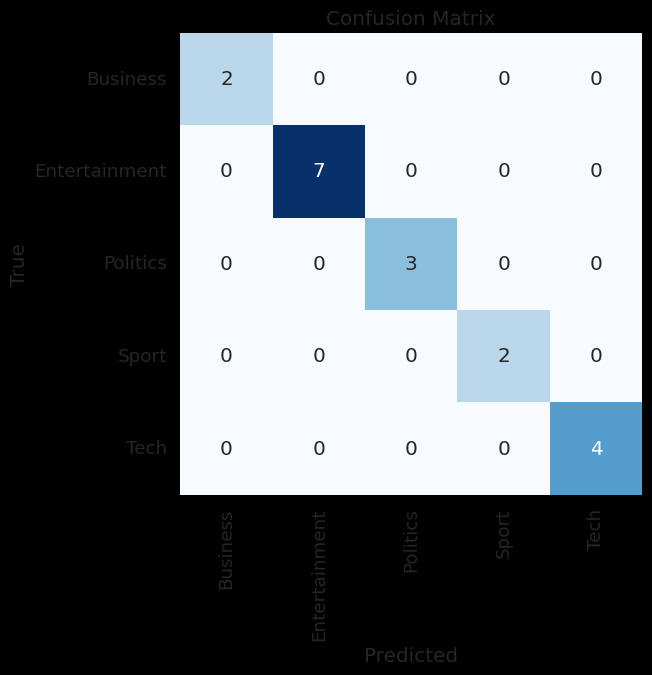

In [33]:
confusion = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=["Business", "Entertainment", "Politics", "Sport", "Tech"], yticklabels=["Business", "Entertainment", "Politics", "Sport", "Tech"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



## Prediction for labeled unknown Sample as DF to test the model


In [35]:
url = 'https://github.com/kiddojazz/Multitext-Classification/blob/master/bbc_data.csv?raw=true'
df_unknown = pd.read_csv(url)
print(df_unknown.sample(5))
print(df_unknown.shape)

                                                   data         labels
1513  Protect whistleblowers, TUC says  The governme...       politics
1327  Hamm bows out for US  Womens football legend M...          sport
1352  Hingis to make unexpected return  Martina Hing...          sport
29    Rapper Jay-Z becomes label boss  Rap star Jay-...  entertainment
1679  UK needs true immigration data  A former Home ...       politics
(2225, 2)


In [36]:
df_unknown = df_unknown[df_unknown['labels'] != 'unknown']
df_unknown.shape

(2042, 2)

In [37]:
df_unknown = df_unknown.sample(30).reset_index(drop=True)
df_unknown.head()

,data,labels
0,X Factor show gets second series TV talent sh...,entertainment
1,Yahoo moves into desktop search Internet gian...,tech
2,Optimism remains over UK housing The UK prope...,business
3,Tindall aiming to earn Lions spot Bath and En...,sport
4,Wilkinson to lead England Fly-half Jonny Wilk...,sport


In [38]:
test_texts = df_unknown['data'].to_list()

# Initialize lists to store predictions
predicted_texts = []
predicted_labels = []

# Iterate through each text
for text in test_texts:
    # Encode text using loaded tokenizer
    predict_input = loaded_tokenizer.encode(text,
                                            truncation=True,
                                            padding=True,
                                            return_tensors="tf")

    # Make prediction using loaded model
    output = loaded_model(predict_input)[0]
    prediction_value = tf.argmax(output, axis=1).numpy()[0]

    # Append results to lists
    predicted_texts.append(text)
    predicted_labels.append(prediction_value)

# Map predicted labels to categories using mapping dictionary
predicted_categories = [mapping[label] for label in predicted_labels]

# Create DataFrame to store predictions
prediction_df = pd.DataFrame({
    'text': predicted_texts,
    'predicted_label': predicted_labels,
    'predicted_category': predicted_categories
})

# Display the DataFrame with predictions
prediction_df.head()

,text,predicted_label,predicted_category
0,X Factor show gets second series TV talent sh...,1,entertainment
1,Yahoo moves into desktop search Internet gian...,4,tech
2,Optimism remains over UK housing The UK prope...,0,business
3,Tindall aiming to earn Lions spot Bath and En...,3,sport
4,Wilkinson to lead England Fly-half Jonny Wilk...,3,sport


In [39]:
comparision_df = pd.concat([df_unknown, prediction_df], axis=1)

comparision_df['Prediction_status'] = comparision_df['labels'] == comparision_df['predicted_category']


accuracy = comparision_df['Prediction_status'].mean() * 100
print(f"\nAccuracy: {accuracy:.2f}%")

comparision_df[['data','labels','predicted_category','Prediction_status']]


Accuracy: 100.00%


,data,labels,predicted_category,Prediction_status
0,X Factor show gets second series TV talent sh...,entertainment,entertainment,True
1,Yahoo moves into desktop search Internet gian...,tech,tech,True
2,Optimism remains over UK housing The UK prope...,business,business,True
3,Tindall aiming to earn Lions spot Bath and En...,sport,sport,True
4,Wilkinson to lead England Fly-half Jonny Wilk...,sport,sport,True
5,Berlin hails European cinema Organisers say t...,entertainment,entertainment,True
6,Asia quake increases poverty risk Nearly two ...,business,business,True
7,"Nat Insurance to rise, say Tories National In...",politics,politics,True
8,Kilroy-Silk quits shameful UKIP Ex-chat show ...,politics,politics,True
9,Crisis ahead in social sciences A national bo...,politics,politics,True
